## Music Exploratory Data Analysis

In [1]:
from music21 import stream, interval, corpus, converter, instrument, metadata
from music21 import note, chord, environment, duration, clef, pitch, key
from music21.stream import Score
from music21.stream import Part
from music21.stream import Measure
import notebook
from datetime import date, timedelta
import random, math, re
import pandas as pd
import pathlib, random, copy
from datetime import date
from builtins import isinstance
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from music21 import instrument, Music21Object
from music21 import note, clef, interval

import pandas as pd
import importlib

class Instruments(object):
    """Encapsulates instrument information for the instruments supported by this framework:
       * music21 module
       * associated music21 class and class instance
       * range of the instrument - (low,high) as pitches
       * pitchRange - (low,high) as pitch pitch space attribute
       * Clef to use
       * transposeDiatonic
       * transposeChromatic
       * transposeText

    Instrument information maintained in resources/music/instruments.json
    Clef information in resources/music/clefs.json

    """
    
    instrument_names=[ 'Alto', 'Bass', 'Bassoon', 'Clarinet', 'Flute', 'Harpsichord', 'Koto', 'Oboe', 'Piano', 'PianoLH', 'PianoRH', 'Soprano', 'Tenor']
    clef_names=['Soprano', 'Alto', 'Tenor', 'Bass', 'Treble', 'Treble8va', 'Treble8vb', 'Bass8va', 'Bass8vb', 'C', 'F', 'G']
    
    def __init__(self, verbose=0, resource_folder ="/Compile/dwbzen/resources/music"):
        self.resource_folder = resource_folder
        self.verbose = verbose
        self.__create_instrument_classes()
        self.__create_clef_classes()

    @staticmethod
    def __create_instance(row:pd.Series) -> Music21Object:
        """Create an instance of a given class.
        
            Args:
                row - a pd.Series that has ''module' and 'class' members
            Returns:
                a module.class instance
        
        """
        module = row['module']
        class_name = row['class']
        my_module = importlib.import_module(module)
        MyClass = getattr(my_module, class_name)
        instance = MyClass()
        return instance
    
    @staticmethod
    def __define_pitch_range(row:pd.Series):
        notes = row['range'].split(",")
        nlow = note.Note(notes[0])
        nhigh = note.Note(notes[1])
        rlow = int(nlow.pitch.ps)
        rhigh = int(nhigh.pitch.ps)
        return [rlow,rhigh]
    
    def __create_instrument_classes(self):
        self.instruments_pd = pd.read_json(self.resource_folder + "/instruments.json", orient="index")
        self.instruments_pd['instance'] = [Instruments.__create_instance(row[1]) for row in self.instruments_pd.iterrows()]
        self.instruments_pd['range_ps'] = [Instruments.__define_pitch_range(row[1]) for row in self.instruments_pd.iterrows()]
        self.instruments_pd.fillna(value={'transposeDiatonic':0}, inplace=True)
        self.instruments_pd.fillna(value={'transposeChromatic':0}, inplace=True)
        self.instruments_pd.fillna(value={'transposeText':'Non-transposing'}, inplace=True)
    
    def __create_clef_classes(self):
        self.clefs_pd = pd.read_json(self.resource_folder + "/clefs.json", orient="index")
        self.clefs_pd['instance'] = [Instruments.__create_instance(row[1]) for row in self.clefs_pd.iterrows()]

    def get_clef(self, clef_name) -> clef.Clef:
        instance = None
        if clef_name in self.clefs_pd.index:
            instance = self.clefs_pd.loc[clef_name]['instance']
        return instance
    
    def get_instrument_clef(self, instrument_name) -> clef.Clef:
        instance = None
        if instrument_name in self.instruments_pd.index:
            clef_name = self.instruments_pd.loc[instrument_name]['clef']
            instance = self.get_clef(clef_name)
        return instance
    
    def get_instrument(self, instrument_name) -> instrument.Instrument:
        instance = None
        if instrument_name in self.instruments_pd.index:
            instance = self.instruments_pd.loc[instrument_name]['instance']
        return instance
    
    def is_in_range(self, instrument_name:str, note:note.Note) -> bool:
        """Return True if a Note is in the rage of a given Instrument, False otherwise
        
        """
        noteps = note.pitch.ps
        rng = self.instruments_pd.loc[instrument_name]['range_ps']
        inrange = (noteps >= rng[0] and noteps <= rng[1])
        return inrange
    
    def check_range(self, instrument_name:str, note:note.Note) -> int:
        """Returns the number of steps a Note is for a given Instrument, 0 otherwise.
        
            Args:
                instrument_name - the name of a supported Instrument
                note - the Note to test
            Returns:
                0 if in range
                if not in range, the #steps (semitones) the note is beyond the range.
                If <0, the Note is below by that number of steps
                If >0 the note is above by that number of steps
            Note:
                If note.octave is None, music21 assumes octave 4 for all notes.
                So 'C' is treated as 'C4' with a pitch.ps value of 60.
                and 'B' is treated as 'B4' with a pitch.ps value of 71.
        
        """
        steps_out_of_range = 0
        noteps = note.pitch.ps
        rng = self.instruments_pd.loc[instrument_name]['range_ps']
        if noteps < rng[0]:
            steps_out_of_range = noteps - rng[0]
        elif noteps > rng[1]:
            steps_out_of_range = noteps - rng[1]
        return int(steps_out_of_range)
    
    def adjust_to_range(self, instrument_name:str, anote:note.Note, inPlace=False) -> note.Note:
        """Adjust the pitch of a Note if out of range.
            If below the instrument range, the note is transposed up by the number of octaves needed to be back in range.
            If above the instrument range, the note is transposed down by the number of octaves needed to be back in range.
        
            Args:
                instrument_name - the name of a supported Instrument
                anote - the Note to test and possibly transpose
                inPlace - if True anote is transposed in place, else a new Note is returned and the original unchanged.
            Returns:
                a new note that is in range. If inPlace is True, the note provided is transposed in place.
                The original note is returned unchanged if already in range.
        
        """
        steps_out_of_range = self.check_range(instrument_name, anote)
        #
        # if the note is out of range for this part (instrument)
        # transpose up an octave is below the range, down an octave if above
        if steps_out_of_range != 0:
            if self.verbose > 1:
                print(f"newnote: {anote.nameWithOctave} out of range for {instrument_name}, by {steps_out_of_range} steps")
            
            noctaves = 1 + ( (abs(steps_out_of_range)-1) // 12)
            semitones = 12 * noctaves
            if steps_out_of_range <0:
                tintval = interval.Interval(semitones)
            elif steps_out_of_range > 0:
                tintval = interval.Interval(-semitones)
            else:
                tintval = interval.Interval(0)
            #
            # transpose does not return a value if inPlace == True
            #
            newnote = anote.transpose(tintval, inPlace=inPlace)
        else:
            newnote = anote
            
        return newnote


In [4]:

class MusicUtils(object):
    """Music utilities
    TODO - the method names are confusing, like score_notes vs. notes_for_score etc. Need to refactor
    
    """
    
    verbose = 0
    C_Major = key.Key('C')
    A_Minor = key.Key('a')
    default_pitch_map = {'Db':'C#', "D-":'C#', 'D#':'Eb', 'Gb':'F#', 'G-':'F#', 'Ab':'G#', 'A-':'G#', 'A#':'Bb' }
     
    @staticmethod
    def get_score(self, file_path:str) -> Score:
        score = None
        file_info = MusicUtils.get_file_info(file_path)
        if file_info['exists']:
                score = converter.parse(file_info['path_text'])
        return score
    
    #
    # get intervals for a Part
    #
    @staticmethod
    def get_part_intervals(apart:Part) -> [dict]:
        intrvals = []
        part_notes = apart.flat.getElementsByClass('Note')
        for ind in range(len(part_notes)-1):
            n1 = part_notes[ind]
            n2 = part_notes[ind+1]
            i = interval.Interval(n1, n2)
            idict = {'note1':n1, 'note2':n2, 'interval':i}
            intrvals.append(idict)
        return intrvals
    
    @staticmethod
    def get_part_notes(apart:Part) -> [note.Note]:
        part_notes = apart.flat.getElementsByClass('Note')
        return part_notes
    
    @staticmethod
    def get_score_intervals(ascore:Score, partname:str=None) -> dict:
        """ Get the intervals for all Parts of a Score as a dict
        
        """
        parts = ascore.getElementsByClass(Part)
        pdict = dict()
        for p in parts:
            pname = p.partName
            if partname is None or pname==partname:
                pdict[pname] = MusicUtils.get_part_intervals(p)
        return pdict
    
    @staticmethod
    def get_score_notes(ascore:Score, partname:str=None) -> dict:
        """Get the Notes for all Parts or the named part of a Score as a dict with the part name as the key, and a [note.Note] as the value.
        
        Note that this does not return Rest or Chord objects
        """
        parts = ascore.getElementsByClass(Part)
        pdict = dict()
        for p in parts:
            pname = p.partName
            if partname is None or pname==partname:
                notes = MusicUtils.get_part_notes(p)
                pdict[pname] = notes
        return pdict

    @staticmethod
    def get_music21_objects_for_score(classinfo, ascore:Score, partnames:[str]=None, partnumbers:[int]=None) ->  (pd.DataFrame,{str},{int}):
        if classinfo is note.Note:
            return MusicUtils.get_notes_for_score(ascore, partnames, partnumbers)
        elif classinfo is interval.Interval:
            return MusicUtils.get_intervals_for_score(ascore, partnames, partnumbers)
        else:
            raise TypeError
    
    @staticmethod
    def get_intervals_for_score(ascore:Score, partnames:[str]=None, partnumbers:[int]=None) ->  (pd.DataFrame,{str},{int}):
        """Get the intervals of specified Parts of a Score as a pandas.DataFrame
        Arguments:
            ascore - a Score instance
            partnames - a list of part names to extract from Score. If None then intervals from all parts are extracted.
        
        DataFrame columns returned:
            interval  (interval.Interval)
            part_name
            part_number
            note1  (note.Note the first Note in the interval pair)
            note2  (note.Note the second Note in the interval pair)
            name (interval name as in "P5")
            directedName  (as in "P-5" for down a 5th)
            niceName
            semitones (int)
        
        Returns a 3-tuplet consisting of the intervals_df DataFrame,
        a [int] of part numbers, and a [str] of part names.
        """
        pdict = MusicUtils.get_score_intervals(ascore)
        intrvals_df = pd.DataFrame()
        part_number = 1
        df = None
        score_partnames = set()
        score_partnumbers = set()
        if partnames is None:
            partnames = list(pdict.keys())
        have_partnames = not ( partnames is None or len(partnames)==0)
        have_partnumbers = not (partnumbers is None or len(partnumbers)==0 or part_number in partnumbers)
        for k in pdict.keys():  # part names
                
                if (have_partnames and k in partnames) or (have_partnumbers and part_number in partnumbers):
                    part_intervals = pdict[k]
                    intervals =  [x['interval'] for x in part_intervals]
                    df = pd.DataFrame(data=intervals, columns=['interval'])
                    df['part_number'] = part_number
                    df['part_name'] = k
                    df['note1'] = [x['note1'] for x in part_intervals]
                    df['note2'] = [x['note2'] for x in part_intervals]
                    score_partnames.add(k)
                    score_partnumbers.add(part_number)
                    intrvals_df = intrvals_df.append(df)
                    part_number = part_number + 1
        if df is not None:
            # else this score has none of the parts specified 
            intrvals_df['name'] = [x.name for x in intrvals_df['interval']]
            intrvals_df['directedName'] = [x.directedName for x in intrvals_df['interval']]
            intrvals_df['niceName'] = [x.niceName for x in intrvals_df['interval']]
            intrvals_df['semitones'] = [x.semitones for x in intrvals_df['interval']]
            intrvals_df.reset_index(drop=True, inplace=True)       # make sure index is unique
        return intrvals_df, score_partnames, score_partnumbers
    

    @staticmethod
    def get_notes_for_score(ascore:Score, partnames:[str]=None, partnumbers:[int]=None) ->  (pd.DataFrame,{str},{int}):
        """Get the Notes of specified Parts from a score as a pandas.DataFrame
        Arguments:
            ascore - a Score instance
            partnames - a list of part names to extract from Score. If None, no parts are extracted.
                        If ['*'] (the default), then notes from all parts are extracted.
                                
        DataFrame columns returned:
            part_name
            part_number
            Note (music21.note.Note)
            name
            nameWithOctave
            pitch (music21.pitch.Pitch)
            duration (music21.duration.Duration)
            pitchClass (int)
        
        Returns a 3-tuple consisting of the notes_df DataFrame,
        an integer list of part numbers, and a str list of part names.
        """
        pdict = MusicUtils.get_score_notes(ascore)
        notes_df = pd.DataFrame()
        df = None
        part_number = 1
        score_partnames = set()
        score_partnumbers = set()
        if partnames is None:
            partnames = list(pdict.keys())
        have_partnames = not ( partnames is None or len(partnames)==0)
        have_partnumbers = not (partnumbers is None or len(partnumbers)==0 or part_number in partnumbers)
        for k in pdict.keys():
            if  (have_partnames and k in partnames) or (have_partnumbers and part_number in partnumbers):
                df = pd.DataFrame(data=pdict[k], columns=['note'])
                df['part_number'] = part_number
                df['part_name'] = k
                score_partnames.add(k)
                score_partnumbers.add(part_number)
                notes_df = notes_df.append(df)
                part_number = part_number + 1
        if df is not None:
            # else this score has none of the parts specified 
            notes_df['name'] = [x.name for x in notes_df['note']]
            notes_df['nameWithOctave'] = [x.nameWithOctave for x in notes_df['note']]
            notes_df['pitch'] = [x.pitch for x in notes_df['note']]
            notes_df['duration'] = [x.duration for x in notes_df['note']]
            notes_df['pitchClass'] = [x.pitch.pitchClass for x in notes_df['note']]
            notes_df.reset_index(drop=True, inplace=True)       # make sure index is unique
        return notes_df, score_partnames, score_partnumbers
    
    @staticmethod
    def get_durations_from_notes(source_df:pd.DataFrame) -> pd.DataFrame:

        """Get the Durations from a notes or intervals DataFrame
        
        The notes_df argument has the columns described in get_notes_for_score().
        DataFrame columns returned:
            note (music21.note.Note)
            duration (music21.duration.Duration)
            type
            ordinal
            dots
            fullName
            quarterLength
            tuplets
        See the music21.duration documentation for details on individual fields
        """
        if 'duration' in source_df.columns:
            notes_df = source_df
            durations_df = pd.DataFrame(data=notes_df[['note','duration']], columns=['note','duration'])
            durations_df['type'] = [x.type for x in notes_df['duration']]
            durations_df['ordinal'] = [x.ordinal for x in notes_df['duration']]
            durations_df['dots'] = [x.dots for x in notes_df['duration']]
            durations_df['fullName'] = [x.fullName for x in notes_df['duration']]
            durations_df['quarterLength'] = [x.quarterLengthNoTuplets for x in notes_df['duration']]
            durations_df['tuplets'] = [x.tuplets for x in notes_df['duration']]
        else:
            intervals_df = source_df
            durations_df = pd.DataFrame(data=intervals_df[['note1']], columns=['note1'])
            durations_df['duration'] = [x.duration for x in intervals_df['note1']]
            durations_df['type'] = [x.duration.type for x in intervals_df['note1']]
            durations_df['ordinal'] = [x.duration.ordinal for x in intervals_df['note1']]
            durations_df['dots'] = [x.duration.dots for x in intervals_df['note1']]
            durations_df['fullName'] = [x.duration.fullName for x in intervals_df['note1']]
            durations_df['quarterLength'] = [x.duration.quarterLengthNoTuplets for x in intervals_df['note1']]
            durations_df['tuplets'] = [x.duration.tuplets for x in intervals_df['note1']]
            durations_df.rename(columns={'note1':'note'}, inplace=True)
        return durations_df
    
    @staticmethod
    def get_metadata_bundle(composer:str=None, title:str=None) -> metadata.bundles.MetadataBundle:
        """Gets a MetadataBundle for a composer and title.
            Arguments:
                composer - composer name, can be None
                title - a regular expression string used to do a title search.
            If title is just a string (no re characters) it will do an exact match.
            For example, to search for all Bach's works (in the corpus) that starts with "bwv1"
            specify get_metadata_bundle(composer='bach', title='^bwv1+')
        
        """
        meta = None
        if title is not None:
            titles_re = re.compile(title, re.IGNORECASE)
        if composer is not None:
            meta = corpus.search(composer,'composer')
            if title is not None:
                meta = meta.intersection(corpus.search(titles_re,'title'))
        elif title is not None:
            meta = corpus.search(titles_re,'title')
        return meta
    
    @staticmethod
    def get_all_score_music21_objects(classinfo, composer=None, title=None, partnames=None, partnumbers=None):
        if classinfo is note.Note:
            return MusicUtils.get_all_score_notes(composer, title, partnames, partnumbers)
        elif classinfo is interval.Interval:
            return MusicUtils.get_all_score_intervals(composer, title, partnames, partnumbers)
        else:
            raise TypeError

    @staticmethod
    def get_all_score_notes(composer=None, title=None, partnames=None, partnumbers=None):
        scores, titles = MusicUtils.get_scores_from_corpus(composer, title)
        notes_df = pd.DataFrame()
        all_score_partnames = set()
        all_score_partnumbers = set()
        for i in range(len(scores)):
            score = scores[i]
            df,pnames,pnums = MusicUtils.get_notes_for_score(score, partnames, partnumbers)
            df['title'] = titles[i]
            notes_df = notes_df.append(df)
            all_score_partnames = all_score_partnames.union(pnames)
            all_score_partnumbers = all_score_partnumbers.union(pnums)
        return notes_df, all_score_partnames, all_score_partnumbers
            
    @staticmethod
    def get_all_score_intervals(composer=None, title=None, partnames=None, partnumbers=None):
        meta = MusicUtils.get_metadata_bundle(composer, title)
        intrvals_df = pd.DataFrame()
        all_score_partnames = set()
        all_score_partnumbers = set()
        for i in range(len(meta)):
            md = meta[i].metadata
            if MusicUtils.verbose > 0:
                    print(f"working on {md.title}")
            score = corpus.parse(meta[i])
            df,pnames,pnums = MusicUtils.get_intervals_for_score(score, partnames, partnumbers)
            if len(df) > 0:
                df['title'] = md.title
                intrvals_df = intrvals_df.append(df)
                all_score_partnames = all_score_partnames.union(pnames)
                all_score_partnumbers = all_score_partnumbers.union(pnums)
        return intrvals_df, all_score_partnames, all_score_partnumbers
    
    @staticmethod
    def get_scores_from_corpus(composer=None, title=None):
        scores = []
        titles = []
        meta = MusicUtils.get_metadata_bundle(composer, title)
        for i in range(len(meta)):
            md = meta[i].metadata
            titles.append(md.title)
            score = corpus.parse(meta[i])
            scores.append(score)
        return scores,titles
    
    @staticmethod
    def show_measures(measures, how='text'):
        nmeasures = len(measures)
        print(f"number of measures: {nmeasures}")
        i = 1
        for measure in measures:
            notes = measure.getElementsByClass(['Note','Chord','Rest'])
            print('measure {}'.format(i))
            for n in notes:
                if n.isNote:
                    print(n.nameWithOctave)
                else:
                    print(n.fullName)
            i = i+1
            measure.show(how)   # if None, displays in MuseScore
    
    @staticmethod
    def show_intervals(df, what='name') -> str:
        int_string = ''
        for ki in df[what].values.tolist():
            int_string = int_string + str(ki) + ','
        return int_string.rstrip(',')
    
    @staticmethod
    def show_notes(df, what='name') -> str:
        """Creates a stringified list of notes from a DataFrame
            Args:
                df - the source DataFrame
                what - the DataFrame column to select
            For example, show_notes(notes_df, 'nameWithOctave'), len(notes_df)==2, would return
            a string like 'F#4,C#5'
        
        """
        notes_str = ''
        for kn in df[what].values.tolist():
            notes_str = notes_str + kn + ','
        return (notes_str.rstrip(','))
    
    @staticmethod
    def show_durations(df, what='quarterLength') -> str:
        duration_string = ''
        for ds in df[what].values.tolist():
            duration_string = duration_string + str(ds) + ','
        return duration_string.rstrip(',')
    
    @staticmethod
    def to_string(alist:[int]) -> str:
        """Stringifies an integer list.
            For example [-2,3] --> "-2,3", because of str(alist) formatting
            str([-2,3]) --> "['2', '3']"
            
        """
        lstr = ''
        for x in alist:
            lstr = lstr + str(x) + ','
        return lstr.rstrip(',')

    @staticmethod
    def note_info(note):
        dur = note.duration
        if note.isRest:
            info = f'name: {note.name}, fullName: {note.fullName}, type: {dur.type}, dots: {dur.dots},\
            quarterLength: {dur.quarterLength}'
        else:
            info = f'{note.nameWithOctave}, type: {dur.type}, dots: {dur.dots},\
            fullName: {dur.fullName}, quarterLength: {dur.quarterLength}, tuplets: {dur.tuplets}'
        return info

    @staticmethod
    def duration_info(dur) -> duration.Duration:
        info = f'type: {dur.type}, ordinal: {dur.ordinal}, dots: {dur.dots}, fullName: {dur.fullName}, \
        quarterLength {dur.quarterLength}, tuplets: {dur.tuplets}'
        return info
    
    @staticmethod
    def get_interval_stats(ascore, partnames=None, partnumbers=None):
        int_df,pnames,pnums = MusicUtils.get_intervals_for_score(ascore, partnames, partnumbers)
        int_df = int_df.groupby(by=['semitones']).count()[['interval']]
        int_df.rename(columns={'interval':'count'}, inplace=True)
        int_df.reset_index(inplace=True)       
        return int_df.sort_values(by='count', ascending=False)

    @staticmethod
    def create_note(start_note:note.Note, 
                    anInterval:interval.Interval=None, semitones:int=None,
                    dur:duration.Duration=None, quarterLen:int=None) -> note.Note:
        """Creates a new Note a given interval away from a starting note
        
        Args:
            start_note (note.Note): the anchor Note
            interval (interval.Interval): a valid Interval or None. If None, semitones must be present.
            semitones (int): interval expressed as semitones
            duration (duration.Duration): duration to assign to the new Note
            quarterLength (int): duration to assign to the new Note expressed as quarterLength
        Returns:
            A new Note that is the specified interval away from the start_note.
        Notes:
            * duration or quarterLength may be specified, but not both.
            * if both duration and quarterLength are none, the duration of the new Note
              will be the same as the duration of start_note
        """
        new_note = copy.copy(start_note)    # shallow copy
        if anInterval is None and semitones is None:
            raise ValueError('interval and semitones cannot both be None')
        intval = anInterval
        if anInterval is None:
            intval = interval.Interval(semitones)
        new_note = new_note.transpose(intval)
        if dur is None and quarterLen is not None:
            new_note.quarterLength = quarterLen
        elif dur is not None:
            new_note.duration = dur
        return new_note
    
    @staticmethod
    def random_notes(lower_ps:int, upper_ps:int, num:int=10, minval=0.5) -> [note.Note]:
        notes = []
        for n in range(num):
            ps = random.randrange(lower_ps,upper_ps)    # random pitch (ps values)
            dur = random.randrange(1, 8) * minval       # random durations as quarterLength
            notes.append(note.Note(ps=ps, quarterLength=dur))
        return notes
    
    @staticmethod
    def random_part(lower_ps:int, upper_ps:int, num:int=10, minval=0.5, 
                     clef=clef.TrebleClef(), instrument=instrument.Piano()):
        # minval is given as quarterLength, 0.5 is an eighth note, 0.25 is a 16th etc.
        part = Part()
        part.insert(0,instrument)
        notes = []
        notes.append(clef)
        for n in range(num):
            ps = random.randrange(lower_ps,upper_ps)    # random pitch (ps value) c4 to b6
            dur = random.randrange(1, 8) * minval    # random durations (multiples of 16th notes) as quarterLength
            notes.append(note.Note(ps=ps, quarterLength=dur))
        part.append(notes)
        return part
    
    @staticmethod
    def get_file_info(cpath:str, def_extension:str='mxl') -> dict:
        """Breaks up a path name into component parts
        
        """
        
        known_extensions = [def_extension, 'mxl','.xml','.musicxml','.json','.txt','.csv']
        x = cpath.split("/")
        paths = x[0:len(x)-1]
        filename = x[-1]
        ext = filename.split(".")
        name = ext[0]
        if len(ext)==2 and ext[1] in known_extensions:
            ext = ext[1]
            path = cpath      
        else:
            ext = def_extension
            filename = f"{filename}.{ext}"
            path = f"{cpath}.{ext}"
        p = pathlib.Path(path)
        exists = p.exists()
        return  {'paths':paths, 'path_text':path, 'filename':filename, 'name':name,'extension': ext, 'Path':p, 'exists':exists}

    @staticmethod
    def round_values(x, places=5):
        if not type(x) is str:
            return round(x, places)
        else:
            return x
    
    @staticmethod
    def get_timedelta(start_date=date(1970,1,1), end_date=date.today()) -> int:
        """Gets the number of elapsed seconds between two dates.
        
        Args:
            start_date (datetime.date): the starting date. Default value is Jan 1,1970
            end_date: the ending date. Default value is today()
        Returns:
            The absolute value of the number of elapsed seconds between the two dates.
        Notes:
            Useful in setting a random seed.
        
        """
        
        delta = end_date - start_date
        return abs(int(delta.total_seconds()))
    
    @staticmethod
    def get_score_parts(aScore:Score):
        """Get the Parts of a Score
        Args:
            aScore - a stream.Score instance
        Returns:
            A dict of stream.Part with the key partName
        
        """
        parts_dict = dict()
        if aScore is not None:
            parts = aScore.getElementsByClass(Part)
            for p in parts:
                parts_dict[p.partName] = p
        return parts_dict
    
    @staticmethod
    def get_keySignatures(apart:Part):
        """Gets the KeySignatures appearing in a given Part
        
            Args:
                apart : a stream.Part instance
            Returns:
                a tupple consisting of 2 lists:
                [KeySignature] in the order of appearance
                [int] of measure numbers where the KeySignature occurs
        """
        measures = apart.getElementsByClass(Measure)
        key_sigs = []
        measure_numbers = []
        for m in measures:
            keys = m.getElementsByClass([key.Key,key.KeySignature])
            for k in keys:
                if k is not None:
                    key_sigs.append(k)
                    measure_numbers.append(m.measureNumber)
        return key_sigs,measure_numbers

    @staticmethod
    def adjust_accidental(aNote:note.Note, preference:object=default_pitch_map, inPlace=True) -> note.Note:
        adjusted_note = aNote
        if not inPlace:
            adjusted_note = copy.deepcopy(aNote)
        if isinstance(preference, dict):
            keys = preference.keys()

        p = adjusted_note.pitch.simplifyEnharmonic()
        if p.accidental is None:
            accidental = 'natural'
        else:
            accidental = p.accidental.name
        if isinstance(preference, dict):
            if p.name in keys:
                p = p.getEnharmonic()
        elif preference=='sharp' and 'flat' in accidental:
                p = p.getEnharmonic()
        elif preference=='flat'  and 'sharp' in accidental:
                p = p.getEnharmonic()
        adjusted_note.pitch = p
        
        return adjusted_note
                
    @staticmethod
    def adjust_accidentals(apart: Part, preference:object=default_pitch_map, inPlace=True) -> Part:
        """Adjusts the accidentals on all notes in a given Part.
            Arguments:
                apart - a music21.stream.Part instance which can be the entire part, or measures()
                preference - "sharp", "flat" or dict() of pitch mappings. Default is default_pitch_map:
                             {'Db':'C#', "D-":'C#', 'D#':'Eb', 'Gb':'F#', 'G-':'F#', 'Ab':'G#', 'A-':'G#', 'A#':'Bb' }
                inPlace - if True changes are applied to the Part argument
            Returns:
                The adjusted Part
        """
        adjusted_part = apart
        if not inPlace:
            adjusted_part = copy.deepcopy(apart)
        part_notes = MusicUtils.get_part_notes(adjusted_part)

        for aNote in part_notes:
            aNote = MusicUtils.adjust_accidental(aNote, preference, inPlace=True)
        return adjusted_part

    @staticmethod
    def adjust_score_accidentals(ascore:Score, preference:object=default_pitch_map, partnames:[str]=None, inPlace=True) -> Score:
        """Adjusts the accidentals on all notes in a given score for specified part names
        
        """
        parts = ascore.getElementsByClass(Part)
        new_score = Score()
        for apart in parts:
            pname = apart.partName
            if partnames is None or pname in partnames:
                tp = MusicUtils.adjust_accidentals(apart, preference, inPlace)
                new_score.append(tp)
        return new_score
    
    @staticmethod
    def get_transposition_intervals(keys:[key.Key], key2:key.Key=C_Major, key2_minor:key.Key=A_Minor) -> [interval.Interval]:
        intval = []
        p2 = None
        for akey in keys:
            k = akey
            if not isinstance(akey, key.Key):
                k = akey.asKey()
            p1 = k.getPitches()[0]
            if k.mode == 'major':
                p2 = key2.getPitches()[0]
            else:
                p2 = key2_minor.getPitches()[0]
                
            interval_p1p2 = interval.Interval(noteStart = p1,noteEnd = p2)
            if abs(interval_p1p2.semitones) > 6:
                interval_p1p2 = interval_p1p2.complement
            if MusicUtils.verbose > 1:
                print('transposition key pitches {}, {} intervals p1p2 {}'.format(p1.nameWithOctave,p2.nameWithOctave, interval_p1p2.semitones))
            intval.append(interval_p1p2)
        return intval
    
    @staticmethod
    def transpose_part(apart:Part, target_key=C_Major, target_key_minor=A_Minor, \
                       instruments:Instruments=None, inPlace=False, adjustAccidentals=True) -> Part:
        """Transpose the notes in a given Part
            Args:
                apart : a stream.Part instance
                target_key : the transposition Key. Default is C-Major if not specified
                target_key_minor : the transposition Key if original key is minor mode. Default is A-Minor if not specified
                instruments - music.Instruments instance, if not None Part ranges are enforced after the transposition
                inPlace - if True, transpose in place. Otherwise transpose a copy
                adjustAccidentals - if True (the default) adjust all accidentals according to the caller's preference
            Returns:
                A Part with the notes transposed as specified.
                The Part argument is not modified if inPlace is False.
        """
        key_sigs,measure_numbers = MusicUtils.get_keySignatures(apart)
        measure_numbers.append(len(apart))
        transposition_intervals = MusicUtils.get_transposition_intervals(key_sigs, key2=target_key, key2_minor=target_key_minor)
        transposed_part = apart
        if not inPlace:     # transpose a copy of the Part
            transposed_part = copy.deepcopy(apart)
            
        for i in range(len(transposition_intervals)):
            #
            # no need to transpose if the measures are already in the target_key
            # but still need to adjust accidentals
            #
            intval = transposition_intervals[i]
            if MusicUtils.verbose > 1:
                print(f"transposition interval: {intval}")
            part_measures = transposed_part.measures(measure_numbers[i], measure_numbers[i+1]-1)
            if intval.semitones != 0:
                part_measures.transpose(intval, inPlace=True)
            if adjustAccidentals:
                MusicUtils.adjust_accidentals(part_measures)   # use defaults for preference and inPlace (True)
        
        if instruments is not None:
            #
            # check if notes are in range for Instrument and adjust if necessary
            #
            for anote in transposed_part.flat.getElementsByClass('Note'):
                instruments.adjust_to_range(apart.partName, anote, inPlace=True)
        
        return transposed_part
    
    @staticmethod
    def transpose_score(ascore:Score, target_key=C_Major, target_key_minor=A_Minor, partnames:[str]=None, \
                        instruments:Instruments=None, inPlace=False, adjustAccidentals=True) -> Score:
        """Transpose an entire Score to a new Key
        
            Args:
                ascore - the Score to transpose
                target_key - the new Key, default is C-Major
                partnames - part names to include (and transpose)
                instruments - music.Instruments instance, if not None Part ranges are enforced after the transposition
                inplace - if True, transpose in place. Otherwise transpose a copy
            Returns:
                a transposed Score. The original is not modified if inPlace is False
        
        """
        parts = ascore.getElementsByClass(Part)
        new_score = Score()
        for p in parts:
            pname = p.partName
            if partnames is None or pname in partnames:
                if MusicUtils.verbose > 1:
                    print('transpose {}'.format(pname))
                tp = MusicUtils.transpose_part(p, target_key=target_key, target_key_minor=target_key_minor, \
                                               instruments=instruments, inPlace=inPlace, adjustAccidentals=adjustAccidentals)
                new_score.append(tp)
        return new_score

if __name__ == '__main__':
    print(MusicUtils.__doc__)


Music utilities
    TODO - the method names are confusing, like score_notes vs. notes_for_score etc. Need to refactor
    
    


### Intervals

In [5]:
meta = MusicUtils.get_metadata_bundle(composer='Bach', title='^bwv[1,4].*')
titles = [meta[i].metadata.title for i in range(len(meta))]
print(f'number of titles: {len(titles)}\n{titles} ')

number of titles: 112
['bwv10.7.mxl', 'bwv101.7.mxl', 'bwv102.7.mxl', 'bwv103.6.mxl', 'bwv104.6.mxl', 'bwv108.6.mxl', 'bwv11.6.mxl', 'bwv110.7.mxl', 'bwv112.5-sc.mxl', 'bwv113.8.mxl', 'bwv114.7.mxl', 'bwv115.6.mxl', 'bwv117.4.mxl', 'bwv121.6.mxl', 'bwv122.6.mxl', 'bwv123.6.mxl', 'bwv126.6.mxl', 'bwv127.5.mxl', 'bwv13.6.mxl', 'bwv133.6.mxl', 'bwv136.6.mxl', 'bwv14.5.mxl', 'bwv140.7.mxl', 'bwv144.3.mxl', 'bwv144.6.mxl', 'bwv145.5.mxl', 'bwv148.6.mxl', 'bwv151.5.mxl', 'bwv153.1.mxl', 'bwv153.5.mxl', 'bwv153.9.mxl', 'bwv154.3.mxl', 'bwv154.8.mxl', 'bwv155.5.mxl', 'bwv156.6.mxl', 'bwv159.5.mxl', 'bwv16.6.mxl', 'bwv161.6.mxl', 'bwv164.6.mxl', 'bwv166.6.mxl', 'bwv168.6.mxl', 'bwv169.7.mxl', 'bwv17.7.mxl', 'bwv172.6.mxl', 'bwv174.5.mxl', 'bwv176.6.mxl', 'bwv177.4.mxl', 'bwv177.5.mxl', 'bwv179.6.mxl', 'bwv18.5-lz.mxl', 'bwv18.5-w.mxl', 'bwv180.7.mxl', 'bwv183.5.mxl', 'bwv184.5.mxl', 'bwv187.7.mxl', 'bwv19.7.mxl', 'bwv194.12.mxl', 'bwv194.6.mxl', 'bwv197.10.mxl', 'bwv197.5.mxl', 'bwv4.8.mxl', 'b

In [6]:
df, pnames,pnums = MusicUtils.get_all_score_intervals(composer='Bach',title='^bwv1+') # ,partnames=['Tenor'])
print(df.head())
print(pnames)
print(pnums)

                          interval  part_number part_name  \
0   <music21.interval.Interval m3>            1   Soprano   
1  <music21.interval.Interval m-3>            1   Soprano   
2   <music21.interval.Interval P1>            1   Soprano   
3   <music21.interval.Interval P1>            1   Soprano   
4   <music21.interval.Interval P1>            1   Soprano   

                   note1                  note2 name directedName  \
0  <music21.note.Note D>  <music21.note.Note F>   m3           m3   
1  <music21.note.Note F>  <music21.note.Note D>   m3          m-3   
2  <music21.note.Note D>  <music21.note.Note D>   P1           P1   
3  <music21.note.Note D>  <music21.note.Note D>   P1           P1   
4  <music21.note.Note D>  <music21.note.Note D>   P1           P1   

         niceName  semitones        title  
0     Minor Third          3  bwv10.7.mxl  
1     Minor Third         -3  bwv10.7.mxl  
2  Perfect Unison          0  bwv10.7.mxl  
3  Perfect Unison          0  bwv10.7.mxl 

### [Notes](https://web.mit.edu/music21/doc/moduleReference/moduleNote.html)


In [4]:
meta = MusicUtils.get_metadata_bundle(composer='Bach', title='^bwv4.*')
titles = [meta[i].metadata.title for i in range(len(meta))]
print(f'number of titles: {len(titles)}\n{titles} ')


number of titles: 52
['bwv4.8.mxl', 'bwv40.3.mxl', 'bwv40.6.mxl', 'bwv40.8.mxl', 'bwv400.mxl', 'bwv401.mxl', 'bwv402.mxl', 'bwv403.mxl', 'bwv404.mxl', 'bwv405.mxl', 'bwv406.mxl', 'bwv407.mxl', 'bwv408.mxl', 'bwv409.mxl', 'bwv41.6.mxl', 'bwv410.mxl', 'bwv411.mxl', 'bwv412.mxl', 'bwv413.mxl', 'bwv414.mxl', 'bwv415.mxl', 'bwv416.mxl', 'bwv417.mxl', 'bwv418.mxl', 'bwv419.mxl', 'bwv42.7.mxl', 'bwv420.mxl', 'bwv421.mxl', 'bwv422.mxl', 'bwv423.mxl', 'bwv424.mxl', 'bwv425.mxl', 'bwv426.mxl', 'bwv427.mxl', 'bwv428.mxl', 'bwv429.mxl', 'bwv43.11.mxl', 'bwv430.mxl', 'bwv431.mxl', 'bwv432.mxl', 'bwv433.mxl', 'bwv434.mxl', 'bwv435.mxl', 'bwv436.mxl', 'bwv437.mxl', 'bwv438.mxl', 'bwv44.7.mxl', 'bwv45.7.mxl', 'bwv46.6.mxl', 'bwv47.5.mxl', 'bwv48.3.mxl', 'bwv48.7.mxl'] 


In [8]:
notes_df, pnames,pnums = MusicUtils.get_all_score_notes(composer='Bach',title='^bwv4.*') # ,partnames=['Tenor'])
print(notes_df.head())
print(pnames)
print(pnums)

                     note  part_number part_name name nameWithOctave pitch  \
0   <music21.note.Note A>            1   Soprano    A             A4    A4   
1  <music21.note.Note G#>            1   Soprano   G#            G#4   G#4   
2   <music21.note.Note A>            1   Soprano    A             A4    A4   
3   <music21.note.Note B>            1   Soprano    B             B4    B4   
4   <music21.note.Note C>            1   Soprano    C             C5    C5   

                          duration  pitchClass       title  
0  <music21.duration.Duration 1.0>           9  bwv4.8.mxl  
1  <music21.duration.Duration 1.0>           8  bwv4.8.mxl  
2  <music21.duration.Duration 0.5>           9  bwv4.8.mxl  
3  <music21.duration.Duration 0.5>          11  bwv4.8.mxl  
4  <music21.duration.Duration 1.0>           0  bwv4.8.mxl  
{'Trumpet 2', 'Timpani', 'Tenor', 'Trumpet 1', 'Oboe 3', 'Trumpet 3', 'Soprano Oboe 1 Violin1', 'Bass', 'Alto', 'Soprano', 'Tenor Viola', 'Bass Continuo', 'Alto Oboe

In [9]:
part_notes_df = notes_df[notes_df['part_name'].apply(lambda v: v=='Soprano' or v=='Alto' or v=='Tenor' or v=='Bass')]
part_notes_df.head(10)

,note,part_number,part_name,name,nameWithOctave,pitch,duration,pitchClass,title
0,<music21.note.Note A>,1,Soprano,A,A4,A4,<music21.duration.Duration 1.0>,9,bwv4.8.mxl
1,<music21.note.Note G#>,1,Soprano,G#,G#4,G#4,<music21.duration.Duration 1.0>,8,bwv4.8.mxl
2,<music21.note.Note A>,1,Soprano,A,A4,A4,<music21.duration.Duration 0.5>,9,bwv4.8.mxl
3,<music21.note.Note B>,1,Soprano,B,B4,B4,<music21.duration.Duration 0.5>,11,bwv4.8.mxl
4,<music21.note.Note C>,1,Soprano,C,C5,C5,<music21.duration.Duration 1.0>,0,bwv4.8.mxl
5,<music21.note.Note D>,1,Soprano,D,D5,D5,<music21.duration.Duration 1.0>,2,bwv4.8.mxl
6,<music21.note.Note C>,1,Soprano,C,C5,C5,<music21.duration.Duration 1.0>,0,bwv4.8.mxl
7,<music21.note.Note B>,1,Soprano,B,B4,B4,<music21.duration.Duration 1.0>,11,bwv4.8.mxl
8,<music21.note.Note A>,1,Soprano,A,A4,A4,<music21.duration.Duration 1.0>,9,bwv4.8.mxl
9,<music21.note.Note A>,1,Soprano,A,A4,A4,<music21.duration.Duration 1.0>,9,bwv4.8.mxl


In [10]:
part_notes_df[['name','nameWithOctave','pitch', 'pitchClass']].groupby(['pitchClass', 'name']).count()


nameWithOctave  pitch
pitchClass name                       
0          C               1255   1255
1          C#               472    472
           D-                46     46
2          D               1764   1764
3          D#               110    110
           E-               323    323
4          E               1428   1428
5          E#                32     32
           F               1015   1015
6          F#               720    720
           G-                 3      3
7          F##                2      2
           G               1458   1458
8          A-               115    115
           G#               332    332
9          A               1773   1773
10         A#                27     27
           B-               713    713
11         B               1007   1007

In [11]:
pitch_counts = part_notes_df[['name', 'pitchClass']].groupby('pitchClass').count()
pitch_counts = pitch_counts.reset_index()
pitch_counts

,pitchClass,name
0,0,1255
1,1,518
2,2,1764
3,3,433
4,4,1428
5,5,1047
6,6,723
7,7,1460
8,8,447
9,9,1773


In [13]:
pitches_list = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']
pitch_counts['pitch_name'] = [ pitches_list[p] for p in pitch_counts['pitchClass']]
pitch_counts

,pitchClass,name,pitch_name
0,0,1255,C
1,1,518,C#
2,2,1764,D
3,3,433,Eb
4,4,1428,E
5,5,1047,F
6,6,723,F#
7,7,1460,G
8,8,447,G#
9,9,1773,A


## Work on existing data

In [19]:
df = pd.read_csv('resources/music/bwv14xx_noteCounts_dpc_01.csv')
df.columns

Index(['KEY', 'G', 'E', 'F', 'D', 'C', 'A', 'B', 'B-', 'F#', 'E-', 'C#', 'G#'], dtype='object')

In [20]:
df

,KEY,G,E,F,D,C,A,B,B-,F#,E-,C#,G#
0,C,233.0,163.0,197.0,936.0,829.0,171.0,1149.0,177.0,16.0,3.0,34.0,27.0
1,G,985.0,197.0,828.0,126.0,469.0,824.0,64.0,9.0,242.0,10.0,11.0,56.0
2,E,152.0,739.0,843.0,1258.0,214.0,427.0,57.0,1.0,217.0,47.0,22.0,17.0
3,F,590.0,1086.0,174.0,128.0,64.0,51.0,28.0,29.0,30.0,36.0,8.0,1.0
4,D,324.0,1094.0,47.0,524.0,1125.0,165.0,102.0,33.0,1.0,51.0,206.0,18.0
5,A,1031.0,236.0,94.0,314.0,110.0,696.0,825.0,144.0,35.0,6.0,14.0,308.0
6,B,162.0,179.0,5.0,47.0,1006.0,780.0,199.0,10.0,4.0,0.0,94.0,30.0
7,B-,30.0,8.0,7.0,6.0,70.0,258.0,9.0,24.0,3.0,5.0,5.0,5.0
8,F#,282.0,96.0,7.0,53.0,3.0,3.0,34.0,0.0,17.0,5.0,0.0,78.0
9,E-,7.0,78.0,14.0,62.0,7.0,1.0,7.0,0.0,1.0,15.0,5.0,1.0


**Rearrange the data with the columns 'pitch' (the KEY column), 'next_pitch' (the column labels) and count**

In [21]:
pitches = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']
pitchCounts_df = pd.DataFrame(columns = ['pitch', 'next_pitch', 'count'])
pitchCounts_df

,pitch,next_pitch,count


In [22]:
pitches = list(df['KEY'])
for c1 in pitches:
    rownum = 0
    for c2 in pitches:
        count = df.iloc[rownum][c2]
        row = {'pitch':c1, 'next_pitch':c2, 'count':count}
        pitchCounts_df = pitchCounts_df.append(row, ignore_index=True)
pitchCounts_df


,pitch,next_pitch,count
0,C,C,829.0
1,C,G,233.0
2,C,E,163.0
3,C,F,197.0
4,C,D,936.0
...,...,...,...
139,G#,B-,177.0
140,G#,F#,16.0
141,G#,E-,3.0
142,G#,C#,34.0


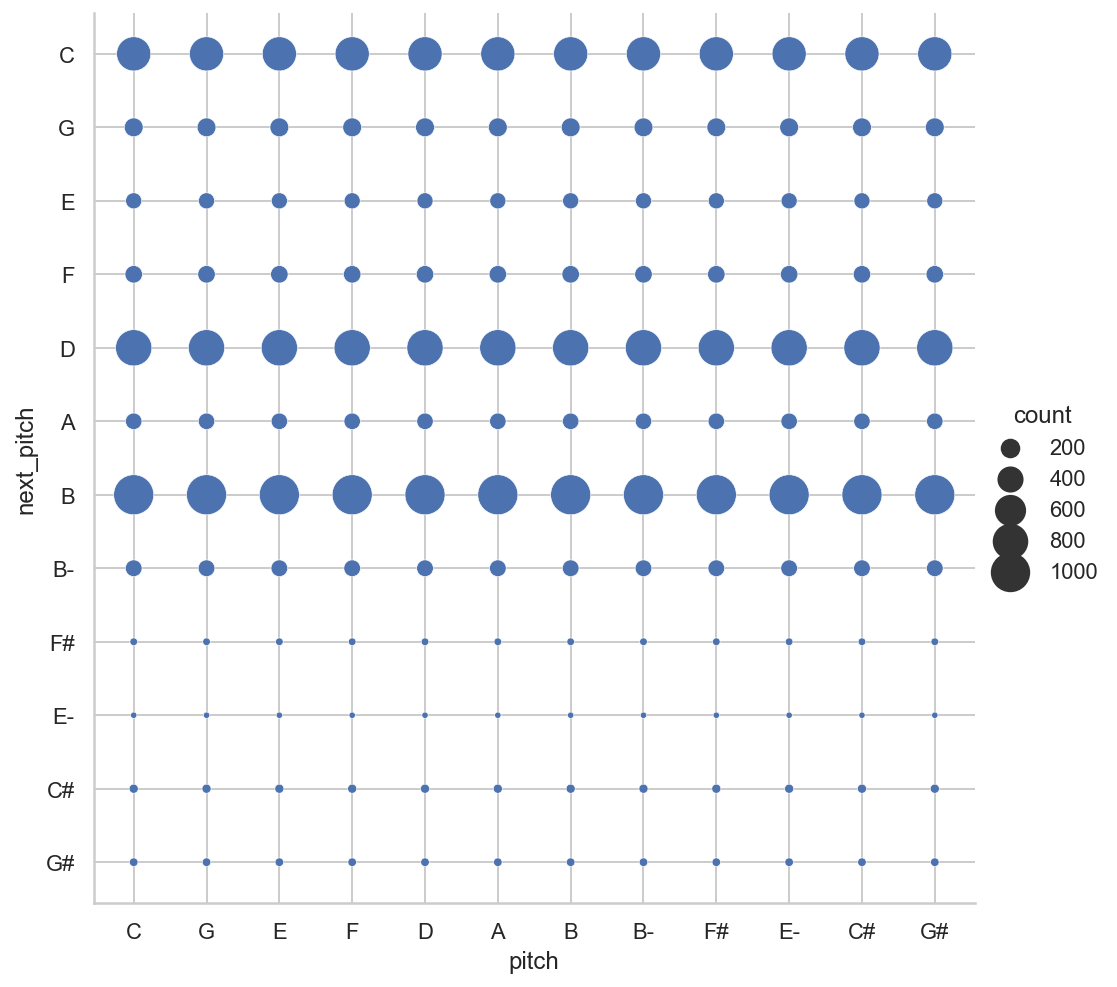

In [26]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.set_theme(style="whitegrid")
g = sns.relplot(data=pitchCounts_df, x='pitch',y='next_pitch', height=7, size='count', sizes=(10,400))
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)

In [27]:
pitchCounts_df[pitchCounts_df['pitch']=='C']

,pitch,next_pitch,count
0,C,C,829.0
1,C,G,233.0
2,C,E,163.0
3,C,F,197.0
4,C,D,936.0
5,C,A,171.0
6,C,B,1149.0
7,C,B-,177.0
8,C,F#,16.0
9,C,E-,3.0
